In [1]:
# Some standard libraries
import numpy as np
import matplotlib.pyplot as plt

# Libraries for creating, running and visualizing quantum circuits 
from qiskit import execute, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import BasicAer
from qiskit.circuit import Parameter
from qiskit.compiler import transpile
from qiskit.tools.visualization import plot_histogram
from IPython.display import display, Math, clear_output

# Libraries for using Quantum Inspire
from quantuminspire.credentials import get_authentication
from quantuminspire.api import QuantumInspireAPI
from quantuminspire.qiskit import QI
from os import getenv
QI_URL = getenv('API_URL', 'https://api.quantum-inspire.com/')

%run CircuitTesting.ipynb

## Circuit

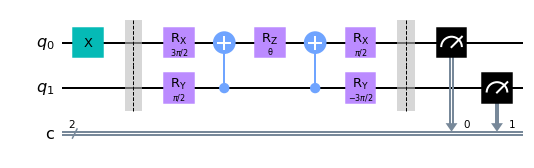

In [2]:
# Initialsiation of circuit
n = 2                        # number of qubits
N = 2**n                     # number of possible (classical) states
q = QuantumRegister(n,'q')   # quantum register of n qubits
c = ClassicalRegister(n,'c') # classical register of 1 bit
qc = QuantumCircuit(q,c)     # quantum circuit on register

theta = Parameter('θ') # create a variable for the z-rotation gate

# Gates
def circuit(qc,q):
    qc.rx(3*np.pi/2,q[0])  #-X(pi/2) gate
    qc.ry(np.pi/2,q[1])    # Y(pi/2) gate
    qc.cnot(q[1],q[0])     # CNOT 1->0
    qc.rz(theta,q[0])      # Z(theta) gate with theta suggested by classical optimizer
    qc.cnot(q[1],q[0])     # CNOT 1->0
    qc.ry(-3*np.pi/2,q[1]) #-Y(pi/2) gate
    qc.rx(np.pi/2,q[0])    # X(pi/2) gate
    
# Apply gates to circuit
circuit(qc,q)
qc.barrier(q)
qc.measure(q,c)
qc = initialise(qc,q,1,c)
display(qc.draw(output='mpl')) # draw circuit using output method matplotlib

In [3]:
N = 40
theta_range = np.linspace(0,2*np.pi,N)
circuits = [qc.bind_parameters({theta: theta_val}) for theta_val in theta_range]

backend = BasicAer.get_backend('qasm_simulator')
job = backend.run(transpile(circuits, backend))
counts = job.result().get_counts()

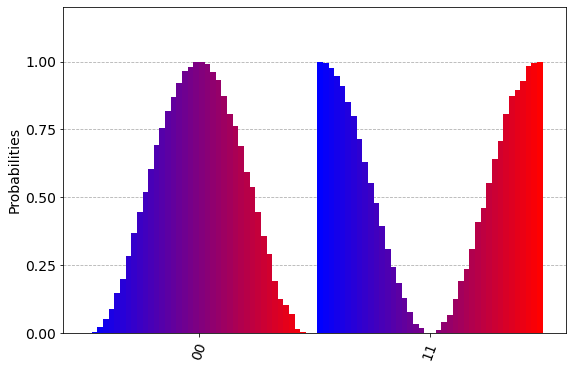

In [4]:
R = np.linspace(0,1,N)
G = np.zeros(N)
B = np.linspace(1,0,N)
cmap = [(r,g,b) for r,g,b in zip(R,G,B)]

fig = plot_histogram(counts,figsize=(9,6),color=cmap,bar_labels=False)
fig.patch.set_facecolor('white')
display(fig)

## Hamiltonian using Qiskit (PyQuante2 driver)

##### Import modules

- `Molecule`: used to create a molecule instance storing all relevant data
- `ElectronicStructureDriverType`: used to specify the driver used in calculations
- `ElectronicStructureMoleculeDriver`: Molecule based electronic structure driver
- `ElectronicStructureProblem`: generates electronic structure problem which we want to solve
- `QubitConverter`: converts hamiltonian from second-quantized to qubit (spin) operators
- `...Mapper`: used by `QubitConverter` to map fermionic operators to qubit operators

- `settings.dict_aux_operators=True` sets `ElectronicStructureProblem` output to dict instead of list

In [5]:
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import (
    ElectronicStructureDriverType,
    ElectronicStructureMoleculeDriver,
)

from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import JordanWignerMapper, ParityMapper, BravyiKitaevMapper
from qiskit_nature import settings
settings.dict_aux_operators = True

##### Create molecule and driver

The geometry of the hydrogen molecule is given as a linear array of 2 hydrogen atoms with a spacing on the z-axis of $0.7414$ Å ($=7.414\cdot10^{-12}$ m). Hydrogen molecules are electrically neutral, so charge $Q=0$ C. Spin multiplicity is defined as $2S+1$, here we assume the singlet state with $S=0$*.

In [6]:
molecule = Molecule(
    geometry=[["H", [0.0, 0.0, 0.0]], ["H", [0.0, 0.0, 0.7414]]], charge=0, multiplicity=1
)
driver = ElectronicStructureMoleculeDriver(
    molecule, basis="sto3g", driver_type=ElectronicStructureDriverType.PYQUANTE
)

###### The spin of a Hydrogen molecule consists of the nuclear spins of both protons ($s=1/2$). The electron spins cancle because they need to be opposite to create a covalent bond between the two atoms. The nuclear spins can be either aligned, forming a triplet state called orthohydrogen with $S=1$, or anti-aligned, forming a singlet state called parahydrogen with $S=0$. At room temperature hydrogen consists for about 25% of parahydrogen. parahydrogen is in a lower energy state than orthohydrogen and since we are searching for the ground state, we use this $S=0$ state.

##### Create electronic structure problem and return second-quantized operators

In [7]:
es_problem = ElectronicStructureProblem(driver)
second_q_op = es_problem.second_q_ops()
print(second_q_op['ElectronicEnergy'])

Fermionic Operator
register length=4, number terms=14
  (0.18128881027902402+0j) * ( +_0 -_1 +_2 -_3 )
+ (-0.181288810279024+0j) * ( +_0 -_1 -_2 +_3 )
+ (-0.181288810279024+0j) * ( -_0 +_1 +_2 -_3 )
+ (0.181288810279024+0j) * ( -_0 +_1 -_2 +_3 )
+ (- ...


##### Convert second-quantized to spin/qubit operators using Jordan Wigner transformation

In [8]:
qubit_converter = QubitConverter(mapper=JordanWignerMapper(), two_qubit_reduction=True)
qubit_op = qubit_converter.convert(second_q_op['ElectronicEnergy'])
print(qubit_op)

-0.812617980644367 * IIII
- 0.22278593632540375 * ZIII
+ 0.17119775959783234 * IZII
+ 0.12054482271376402 * ZZII
- 0.22278593632540372 * IIZI
+ 0.17434844455135634 * ZIZI
+ 0.16586702528352001 * IZZI
+ 0.17119775959783218 * IIIZ
+ 0.16586702528352001 * ZIIZ
+ 0.1686221935535855 * IZIZ
+ 0.12054482271376402 * IIZZ
+ 0.045322202569756 * XXXX
+ 0.045322202569756 * YYXX
+ 0.045322202569756 * XXYY
+ 0.045322202569756 * YYYY


##### Convert second-quantized to spin/qubit operators using Bravyi-Kitaev transformation

In [9]:
qubit_converter = QubitConverter(mapper=BravyiKitaevMapper(), two_qubit_reduction=True)
qubit_op = qubit_converter.convert(second_q_op['ElectronicEnergy'])
print(qubit_op)

-0.812617980644367 * IIII
+ 0.17119775959783234 * IZII
+ 0.12054482271376402 * IIZI
+ 0.12054482271376402 * ZIZI
- 0.22278593632540375 * ZZZI
+ 0.17119775959783218 * IIIZ
+ 0.1686221935535855 * IZIZ
+ 0.17434844455135634 * ZZIZ
- 0.22278593632540372 * IIZZ
+ 0.16586702528352001 * IZZZ
+ 0.16586702528352001 * ZZZZ
+ 0.045322202569756 * IXIX
+ 0.045322202569756 * ZXIX
- 0.045322202569756 * IXZX
- 0.045322202569756 * ZXZX


##### Convert second-quantized to spin/qubit operators using Parity mapper, which uses known symmetries to reduce the problem to 2 qubits

In [10]:
qubit_converter = QubitConverter(mapper=ParityMapper(), two_qubit_reduction=True)
qubit_op = qubit_converter.convert(second_q_op['ElectronicEnergy'], num_particles=es_problem.num_particles)
print(qubit_op)

-1.0537076260718947 * II
+ (-0.39398369592323595-1.3877787807814457e-17j) * ZI
+ (0.3939836959232358-4.163336342344337e-17j) * IZ
- 0.011236587537901799 * ZZ
+ 0.18128881027902394 * XX


## Expectation values $\langle H(\theta) \rangle$

## Ground state solver using VQE